In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import tensorflow as tf
print(tf.__version__)
# Set random seed for reproducibility
tf.random.set_seed(42)


2.15.0


In [2]:
# Load the .npz file
loaded_data = np.load('../datasets/windows.npz', allow_pickle=True)



# Extract the column names
column_names = loaded_data['column_names']

# Convert the loaded data back to a dictionary of lists of DataFrames, using the column names
windows_df = {label: [pd.DataFrame(array, columns=column_names) for array in arrays_list] 
              for label, arrays_list in loaded_data.items() if label != 'column_names'}

# Loop through windows_df and set 'Datetime' as the index and drop unwanted columns
for label, windows_list in windows_df.items():
    for i, window in enumerate(windows_list):
        # Convert 'Datetime' to a datetime object
        window['Datetime'] = pd.to_datetime(window['Datetime'])

        # Set 'Datetime' as the index
        window.set_index('Datetime', inplace=True)

        # Drop 'rhumid' and 'atmpr' columns
        window.drop(['rhumid', 'atmpr'], axis=1, inplace=True)

        # Assign the modified window back to the list
        windows_df[label][i] = window

        
windows_df['Song'][0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2024-04-02 12:15:00 to 2024-04-02 13:30:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   co2            76 non-null     object
 1   tempF          76 non-null     object
 2   door1          76 non-null     object
 3   door2          76 non-null     object
 4   hvac           76 non-null     object
 5   subject_count  76 non-null     object
 6   lecturer       76 non-null     object
dtypes: object(7)
memory usage: 4.8+ KB


## Preprocessing Dataframes Functions

In [3]:
import pandas as pd

def preprocess_dataframes(data_dict, column_names, rolling_features):
    """
    Preprocesses each DataFrame in a dictionary by calculating rolling statistics and lag features for specified columns.
    
    Parameters:
    data_dict (dict): Dictionary where keys are labels and values are lists of pandas DataFrames.
    column_names (list): List of column names to preprocess (e.g., ['co2', 'tempF']).
    rolling_features (dict): Dictionary specifying the rolling window sizes and which features to compute.
                             Format: {'mean': [3, 5], 'std': [5], 'lag': [1, 2], 'diff': True}
                             
    Returns:
    None: Modifies the DataFrames in place.
    """
    for label, windows_list in data_dict.items():
        for window in windows_list:
            for column_name in column_names:  # Iterate over each column name
                # Ensure the specified column is numeric
                window[column_name] = pd.to_numeric(window[column_name], errors='coerce')
                
                # Calculate rolling mean and standard deviation
                if 'mean' in rolling_features:
                    for size in rolling_features['mean']:
                        window[f'{column_name}_ma{size}'] = window[column_name].rolling(window=size, min_periods=1).mean()
                if 'std' in rolling_features:
                    for size in rolling_features['std']:
                        window[f'{column_name}_std{size}'] = window[column_name].rolling(window=size, min_periods=1).std()
                        window[f'{column_name}_std{size}'] = window[f'{column_name}_std{size}'].fillna(method='bfill')
                
                # Create lag features
                if 'lag' in rolling_features:
                    for lag in rolling_features['lag']:
                        window[f'{column_name}_lag{lag}'] = window[column_name].shift(lag).fillna(method='bfill')

                # Create difference feature
                if 'diff' in rolling_features and rolling_features['diff']:
                    window[f'{column_name}_diff'] = window[column_name].diff().fillna(0)

            # Sort columns alphabetically
            window.sort_index(axis=1, inplace=True)

# Example usage:
rolling_features_config = {
    'mean': [3, 5, 7],
    'std': [5, 10],
    'lag': [1, 3, 5],  # Handles a list of lag values
    'diff': True
}
column_names = ['co2']  # Specify the columns to preprocess
preprocess_dataframes(windows_df, column_names, rolling_features_config)

# Example: Display the first DataFrame for 'Song' label after preprocessing
windows_df['Song'][0].head(10)


,co2,co2_diff,co2_lag1,co2_lag3,co2_lag5,co2_ma3,co2_ma5,co2_ma7,co2_std10,co2_std5,door1,door2,hvac,lecturer,subject_count,tempF
Datetime,,,,,,,,,,,,,,,,
2024-04-02 12:15:00,460.0,0.0,460.0,460.0,460.0,460.000000,460.000000,460.000000,16.263456,16.263456,1,1,0,1,3.0,84.7
2024-04-02 12:16:00,437.0,-23.0,460.0,460.0,460.0,448.500000,448.500000,448.500000,16.263456,16.263456,1,1,0,1,3.0,84.9
2024-04-02 12:17:00,452.0,15.0,437.0,460.0,460.0,449.666667,449.666667,449.666667,11.676187,11.676187,1,1,0,1,3.0,85.0
2024-04-02 12:18:00,447.0,-5.0,452.0,460.0,460.0,445.333333,449.000000,449.000000,9.626353,9.626353,1,1,0,1,3.0,85.1
2024-04-02 12:19:00,452.0,5.0,447.0,437.0,460.0,450.333333,449.600000,449.600000,8.443933,8.443933,1,1,0,1,3.0,85.1
2024-04-02 12:20:00,438.0,-14.0,452.0,452.0,460.0,445.666667,445.200000,447.666667,8.914408,7.328028,1,1,0,1,3.0,85.2
2024-04-02 12:21:00,460.0,22.0,438.0,447.0,437.0,450.000000,449.800000,449.428571,9.378293,8.074652,1,1,0,1,3.0,85.4
2024-04-02 12:22:00,451.0,-9.0,460.0,452.0,452.0,449.666667,449.600000,448.142857,8.700369,8.018728,1,1,0,1,3.0,85.6
2024-04-02 12:23:00,825.0,374.0,451.0,438.0,447.0,578.666667,525.200000,503.571429,125.389393,167.778723,1,1,0,1,3.0,85.5


## Stack Dataframes Function

In [4]:
import numpy as np

def stack_dataframes_with_labels(data_dict):
    """
    Converts a dictionary of lists of DataFrames into a stacked 3D NumPy array and creates a label array.
    
    Parameters:
    data_dict (dict): Dictionary where keys are labels and values are lists of pandas DataFrames.
    
    Returns:
    tuple: A tuple containing:
           - A 3D NumPy array if all DataFrames have the same shape, otherwise an object array.
           - A NumPy array of labels corresponding to each DataFrame.
    """
    all_arrays = []
    label_list = []
    
    # Collect all 2D arrays from the DataFrame and corresponding labels
    for label, windows_list in data_dict.items():
        for window in windows_list:
            # Convert DataFrame to NumPy array and add to the list
            all_arrays.append(window.values)
            # Append the corresponding label to the label list
            label_list.append(label)
    
    # Attempt to stack all 2D arrays into a 3D array
    try:
        X = np.stack(all_arrays, axis=0)
        print("Successfully stacked all DataFrames into a 3D NumPy array.")
    except ValueError as e:
        print("Error stacking arrays. This might be due to differing shapes:", str(e))
        # If shapes differ, use a general Python list or an array of objects
        X = np.array(all_arrays, dtype=object)
        print("Stored arrays in an object dtype array.")
    
    # Convert the label list to a NumPy array
    y = np.array(label_list)
    
    print("Shape of the final array X:", X.shape)
    print("Shape of the labels array y:", y.shape)
    return X, y

# Example usage
# Assuming windows_df is your input dictionary
stacked_array, labels_array = stack_dataframes_with_labels(windows_df)



Successfully stacked all DataFrames into a 3D NumPy array.
Shape of the final array X: (27, 76, 16)
Shape of the labels array y: (27,)


In [5]:
def find_divisors(n):
    divisors = [i for i in range(1, n + 1) if n % i == 0]
    return divisors

# Find divisors of 76
divisors_of_76 = find_divisors(76)
print("Divisors of 76:", divisors_of_76)

Divisors of 76: [1, 2, 4, 19, 38, 76]


We create three cases to explore and copy our design matrix `X` to each. Our first case will use the sequence of the first 60 records in each lecture of to predict the last 16 records (minutes). We will split X into a training and test set in which we will train our `LSTM` model to on the first 60 and last 16 records of the training set and then test how well that model generalizes to new data with the test sequence.

# Case I


In [6]:
C1 = windows_df
C1['Song'][0].head()

,co2,co2_diff,co2_lag1,co2_lag3,co2_lag5,co2_ma3,co2_ma5,co2_ma7,co2_std10,co2_std5,door1,door2,hvac,lecturer,subject_count,tempF
Datetime,,,,,,,,,,,,,,,,
2024-04-02 12:15:00,460.0,0.0,460.0,460.0,460.0,460.000000,460.000000,460.000000,16.263456,16.263456,1,1,0,1,3.0,84.7
2024-04-02 12:16:00,437.0,-23.0,460.0,460.0,460.0,448.500000,448.500000,448.500000,16.263456,16.263456,1,1,0,1,3.0,84.9
2024-04-02 12:17:00,452.0,15.0,437.0,460.0,460.0,449.666667,449.666667,449.666667,11.676187,11.676187,1,1,0,1,3.0,85.0
2024-04-02 12:18:00,447.0,-5.0,452.0,460.0,460.0,445.333333,449.000000,449.000000,9.626353,9.626353,1,1,0,1,3.0,85.1
2024-04-02 12:19:00,452.0,5.0,447.0,437.0,460.0,450.333333,449.600000,449.600000,8.443933,8.443933,1,1,0,1,3.0,85.1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X1, y = stack_dataframes_with_labels(C1)
T = X1.astype(np.float64)
# Encode labels: 'Song' as 1, 'Chen' as 0
y = np.array([1 if label == 'Song' else 0 for label in y])
# Scale the features using StandardScaler

# Reshape X to 2D array
T_2d = T.reshape(-1, T.shape[-1])

# Scale the features using StandardScaler
scaler = StandardScaler()
T_scaled = scaler.fit_transform(T_2d)

# Reshape X_scaled back to 3D array
T_scaled_3d = T_scaled.reshape(T.shape[0], T.shape[1], T.shape[2])

# Split into training and test/validation sets
T_train, T_test, y_train, y_test = train_test_split(T_scaled_3d, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", T_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", T_test.shape)
print("y_test shape:", y_test.shape)

Successfully stacked all DataFrames into a 3D NumPy array.
Shape of the final array X: (27, 76, 16)
Shape of the labels array y: (27,)
X_train shape: (21, 76, 16)
y_train shape: (21,)
X_test shape: (6, 76, 16)
y_test shape: (6,)


## Sequential Classification Model

In [8]:
import tensorflow as tf
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[76,16]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='softmax'))

In [9]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(T_train, y_train, epochs=10, validation_data=(T_test, y_test))


Epoch 1/10


1/1 [==============================] - 0s 444ms/step - loss: 2.8970 - accuracy: 0.1429 - val_loss: 2.4255 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 22ms/step - loss: 2.1248 - accuracy: 0.5238 - val_loss: 1.9188 - val_accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 0s 21ms/step - loss: 1.5515 - accuracy: 0.8571 - val_loss: 1.5203 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 0s 22ms/step - loss: 1.1310 - accuracy: 1.0000 - val_loss: 1.2264 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 21ms/step - loss: 0.8399 - accuracy: 1.0000 - val_loss: 1.0136 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 21ms/step - loss: 0.6384 - accuracy: 1.0000 - val_loss: 0.8499 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 21ms/step - loss: 0.4944 - accuracy: 1.0000 - val_loss: 0.7281 - val_accuracy: 1.0000
Epoch 8/10
1/1 [=======

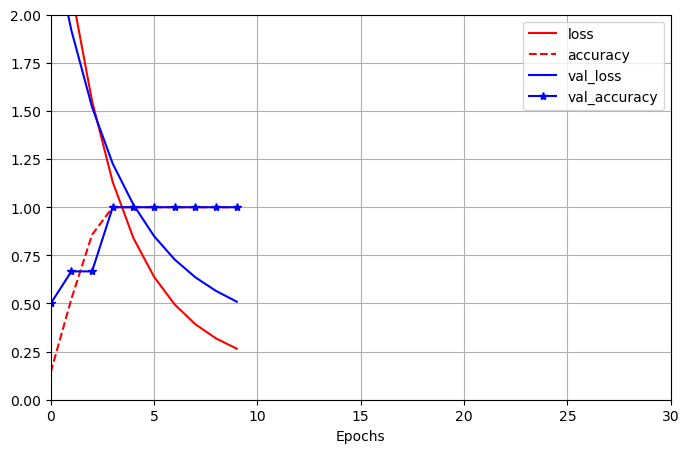

In [10]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 30], ylim=[0, 2], xlabel='Epochs', grid=True,
    style=['r', 'r--', 'b', 'b-*'])
plt.show()

In [11]:
print(model.evaluate(T_test, y_test))
y_proba = model.predict(T_test)
y_proba.round(2)
y_pred = np.argmax(y_proba, axis=1)
y_pred, y_test

1/1 [==============================] - 0s 17ms/step - loss: 0.5093 - accuracy: 1.0000
[0.5093364119529724, 1.0]
1/1 [==============================] - 0s 70ms/step


(array([1, 0, 0, 1, 0, 1], dtype=int64), array([1, 0, 0, 1, 0, 1]))

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification(y_true, y_pred, average='macro'):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Return metrics as a dictionary
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

# Example usage (ensure y_test and y_pred are defined appropriately)
metrics = evaluate_classification(y_test, y_pred)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


## LSTM Model

In [13]:
# Assuming T_train and T_test are your 3D NumPy arrays and have a sufficient number of columns

# Calculate the indices of the columns to keep
cols_to_keep = [i for i in range(T_train.shape[2]) if i not in (11, 12, 14, 15)]  # Corrected to make it a tuple

# Slice the array to keep only the desired columns
T_train = T_train[:, :, cols_to_keep]
T_test = T_test[:, :, cols_to_keep]
print("New shape of T_train after removing column(s) 11:", T_train.shape)  # Fixed variable name in print statement

# Calculating the split index for 80% of the time steps (corrected from 90% to match split_index calculation)
split_index = int(0.8 * T_train.shape[1])  # Adjust to match your data's dimensions if necessary

# Splitting the training data
X_train = T_train[:, :split_index, :]
y_train = T_train[:, split_index:, :]

# Splitting the testing data
X_test = T_test[:, :split_index, :]
y_test = T_test[:, split_index:, :]

# Print shapes to confirm the setup
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)  
print("X_test shape:", X_test.shape)    
print("y_test shape:", y_test.shape)    
  

New shape of T_train after removing column(s) 11: (21, 76, 12)
X_train shape: (21, 60, 12)
y_train shape: (21, 16, 12)
X_test shape: (6, 60, 12)
y_test shape: (6, 16, 12)


In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Print shapes for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



# # Define the model
# model = tf.keras.Sequential([
#     tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(15, 7)),  # Input layer
#     tf.keras.layers.Dense(16, activation='relu'),  # Hidden layer
#     tf.keras.layers.Dense(4 * 7, activation=None)  # Output layer to predict 16 timesteps, each with 20 features
# ])
# model.add(tf.keras.layers.Reshape((4, 7)))  # Reshape output to match (16, 20)

# Define the LSTM model with dropout
model = tf.keras.Sequential([
    # Adding dropout and recurrent dropout to the LSTM layer
    tf.keras.layers.LSTM(32, activation='relu', input_shape=(60, 12),
                         dropout=0.2, recurrent_dropout=0.2),
    # Adding L2 regularization to the Dense layer
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # Output layer to predict 8 timesteps, each with 20 features
    tf.keras.layers.Dense(16 * 12, activation=None)
])
model.add(tf.keras.layers.Reshape((16, 12)))  # Reshape output to match (8, 20)


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_mae', patience=40, restore_best_weights=True)

# Define optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), callbacks=[early_stopping])

X_train shape: (21, 60, 12)
y_train shape: (21, 16, 12)
X_test shape: (6, 60, 12)
y_test shape: (6, 16, 12)
Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 1.4155 - mae: 0.8058 - val_loss: 1.7245 - val_mae: 0.8619
Epoch 2/2000
1/1 [==============================] - 0s 34ms/step - loss: 1.4134 - mae: 0.8056 - val_loss: 1.7242 - val_mae: 0.8619
Epoch 3/2000
1/1 [==============================] - 0s 36ms/step - loss: 1.4135 - mae: 0.8055 - val_loss: 1.7239 - val_mae: 0.8618
Epoch 4/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.4148 - mae: 0.8061 - val_loss: 1.7235 - val_mae: 0.8617
Epoch 5/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.4117 - mae: 0.8053 - val_loss: 1.7230 - val_mae: 0.8617
Epoch 6/2000
1/1 [==============================] - 0s 36ms/step - loss: 1.4125 - mae: 0.8054 - val_loss: 1.7224 - val_mae: 0.8616
Epoch 7/2000
1/1 [==============================] - 0s 37ms/step - loss: 1.4092 - mae: 0.8053 - val_loss: 1.

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions on test set
y_pred = model.predict(X_test)

# Flatten the predictions and actual values for metric calculations
y_true_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

# Calculate metrics
test_mae = mean_absolute_error(y_true_flat, y_pred_flat)
test_rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
test_r2 = r2_score(y_true_flat, y_pred_flat)

# Print the metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R-squared: {test_r2:.4f}')


# Extracting predictions for CO2 (assuming it's the first column in the output)
y_pred_co2 = y_pred[:, :, 0]  # Adjust the index if CO2 is not the first column
y_true_co2 = y_test[:, :, 0]

# Flatten the CO2 predictions and actual values
y_true_co2_flat = y_true_co2.reshape(-1)
y_pred_co2_flat = y_pred_co2.reshape(-1)

# Calculate metrics for CO2
test_mae_co2 = mean_absolute_error(y_true_co2_flat, y_pred_co2_flat)
test_rmse_co2 = np.sqrt(mean_squared_error(y_true_co2_flat, y_pred_co2_flat))
test_r2_co2 = r2_score(y_true_co2_flat, y_pred_co2_flat)

# Print the metrics for CO2
print(f'Test MAE for CO2: {test_mae_co2:.4f}')
print(f'Test RMSE for CO2: {test_rmse_co2:.4f}')
print(f'Test R-squared for CO2: {test_r2_co2:.4f}')

1/1 [==============================] - 0s 202ms/step
Test MAE: 0.5077
Test RMSE: 1.0526
Test R-squared: 0.2578
Test MAE for CO2: 0.4046
Test RMSE for CO2: 0.7835
Test R-squared for CO2: 0.3324


In [16]:
import numpy as np
from sklearn.metrics import r2_score

def calculate_r2_per_feature(y_true, y_pred):
    """
    Calculates the R-squared score for each feature across all timesteps.
    Args:
    y_true (numpy.ndarray): True values of the test set.
    y_pred (numpy.ndarray): Predicted values from the model.
    
    Returns:
    dict: A dictionary with feature indices as keys and R-squared scores as values.
    """
    r2_scores = {}
    for feature_index in range(y_true.shape[2]):  # Assuming the last dimension represents features
        y_true_feature = y_true[:, :, feature_index].reshape(-1)
        y_pred_feature = y_pred[:, :, feature_index].reshape(-1)
        r2_scores[feature_index] = r2_score(y_true_feature, y_pred_feature)
    return r2_scores

# Assuming y_test and y_pred are already defined and contain the test and predicted data respectively.
r2_scores = calculate_r2_per_feature(y_test, y_pred)
print("R-squared scores for each feature:", r2_scores)

R-squared scores for each feature: {0: 0.3324152139693558, 1: -0.02335416831416981, 2: 0.41195335275981104, 3: 0.566140162050728, 4: 0.7056882847803612, 5: 0.39159998107516614, 6: 0.5035353945909666, 7: 0.5982999620431362, 8: 0.023081942721143167, 9: -0.02022170547593971, 10: 0.14513670323445893, 11: 0.6202147031601968}


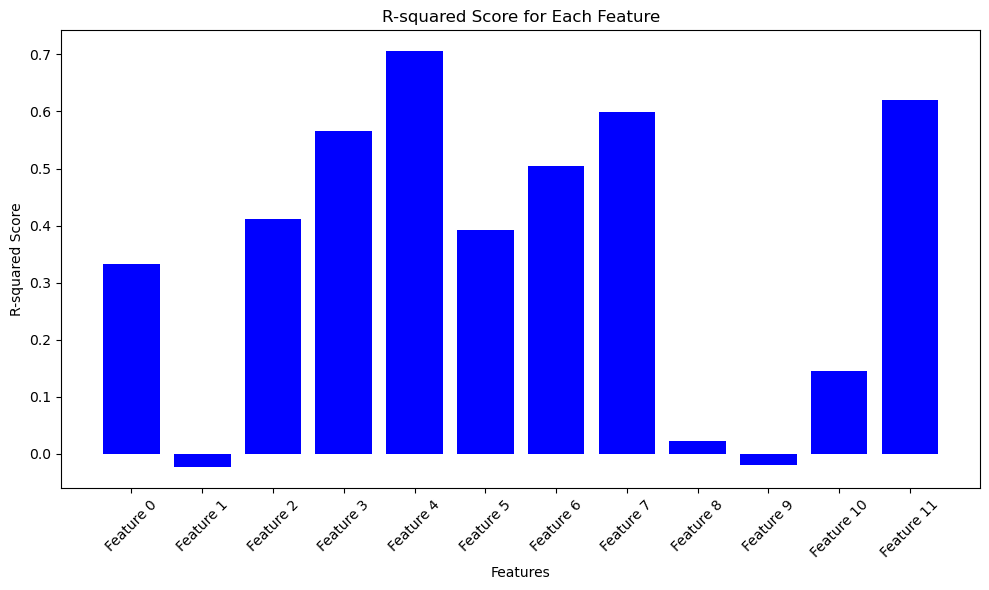

In [17]:
import matplotlib.pyplot as plt

# Extract feature names if available or use generic names
feature_names = ['Feature {}'.format(i) for i in range(y_test.shape[2])]  # Adjust or replace with actual names

# Extract R2 values and sort by value
r2_values = [r2_scores[i] for i in sorted(r2_scores)]

plt.figure(figsize=(10, 6))
plt.bar(feature_names, r2_values, color='blue')
plt.xlabel('Features')
plt.ylabel('R-squared Score')
plt.title('R-squared Score for Each Feature')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

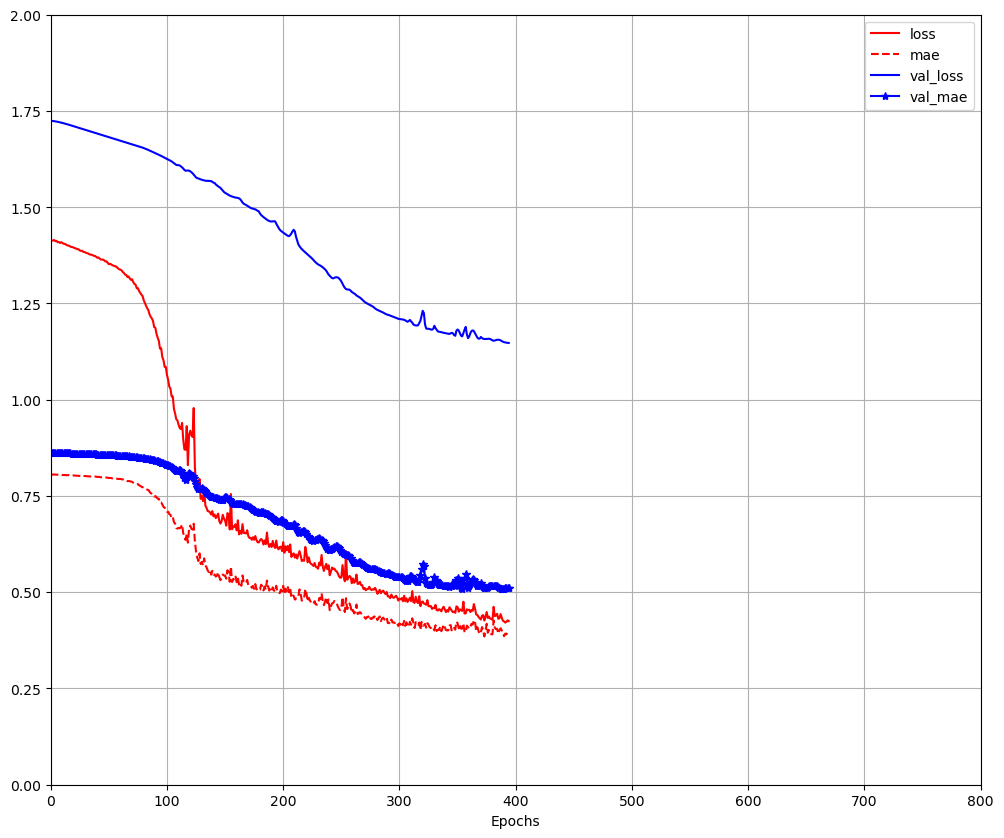

In [18]:
pd.DataFrame(history.history).plot(
    figsize=(12, 10),
    xlim=[0, 800], ylim=[0, 2], xlabel='Epochs', grid=True,
    style=['r', 'r--', 'b', 'b-*'])
plt.show()

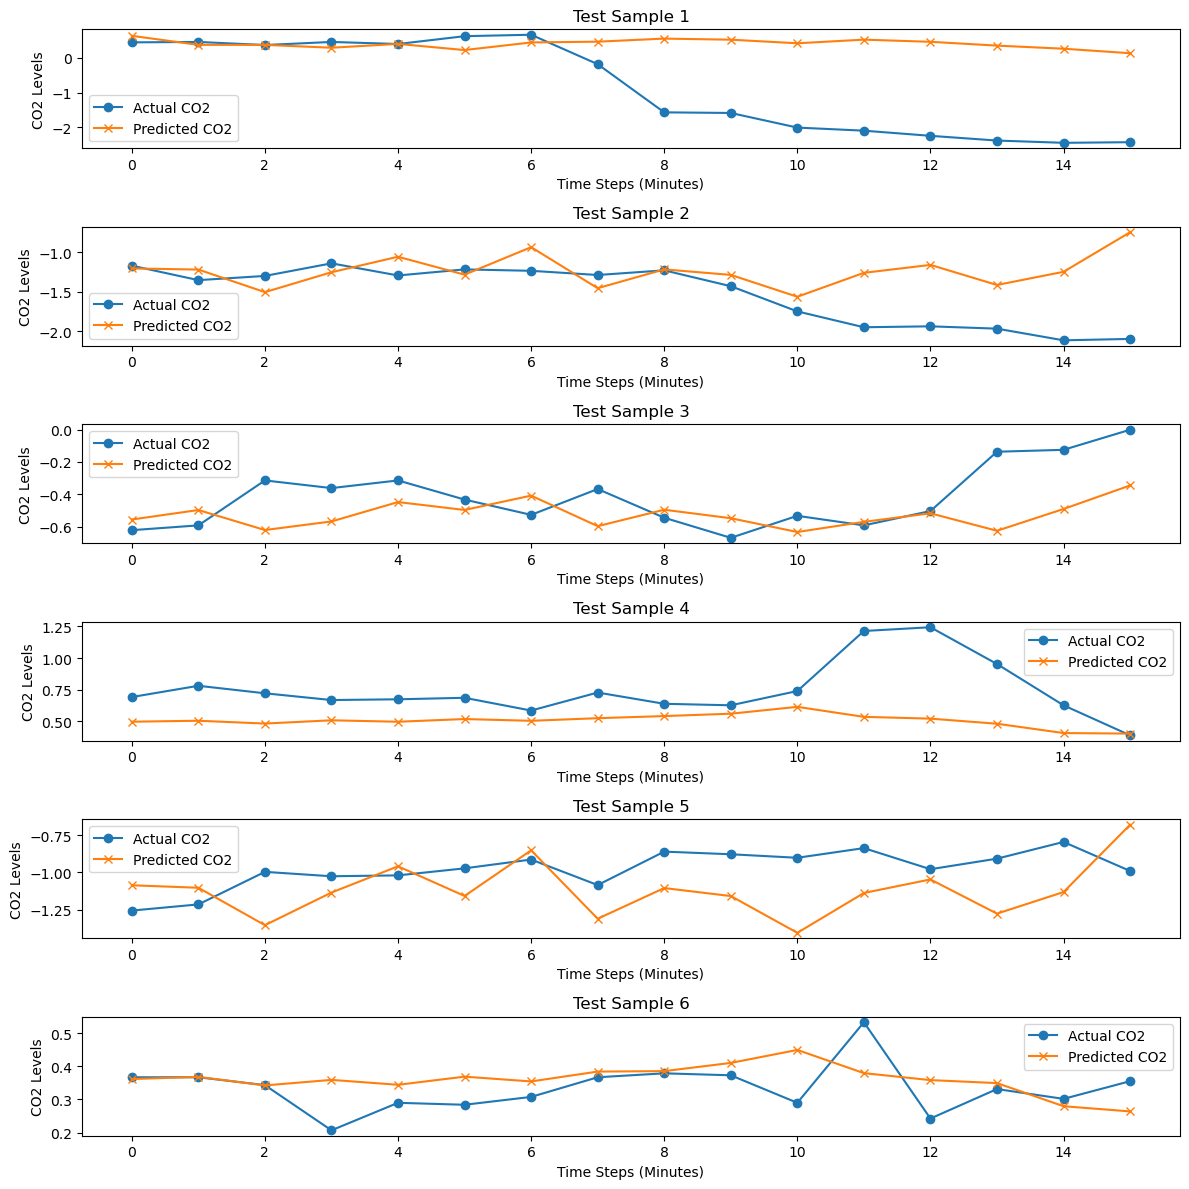

In [19]:
# Assuming y_pred_co2 and y_true_co2 are available from the model's predictions

# Calculate the number of test samples
n_test_samples = y_test.shape[0]

# Setup the plot
plt.figure(figsize=(12, 12))
for i in range(n_test_samples):
    plt.subplot(n_test_samples, 1, i + 1)
    plt.plot(y_true_co2[i], label='Actual CO2', marker='o')
    plt.plot(y_pred_co2[i], label='Predicted CO2', marker='x')
    plt.title(f'Test Sample {i+1}')
    plt.xlabel('Time Steps (Minutes)')
    plt.ylabel('CO2 Levels')
    plt.legend()

plt.tight_layout()
plt.show()


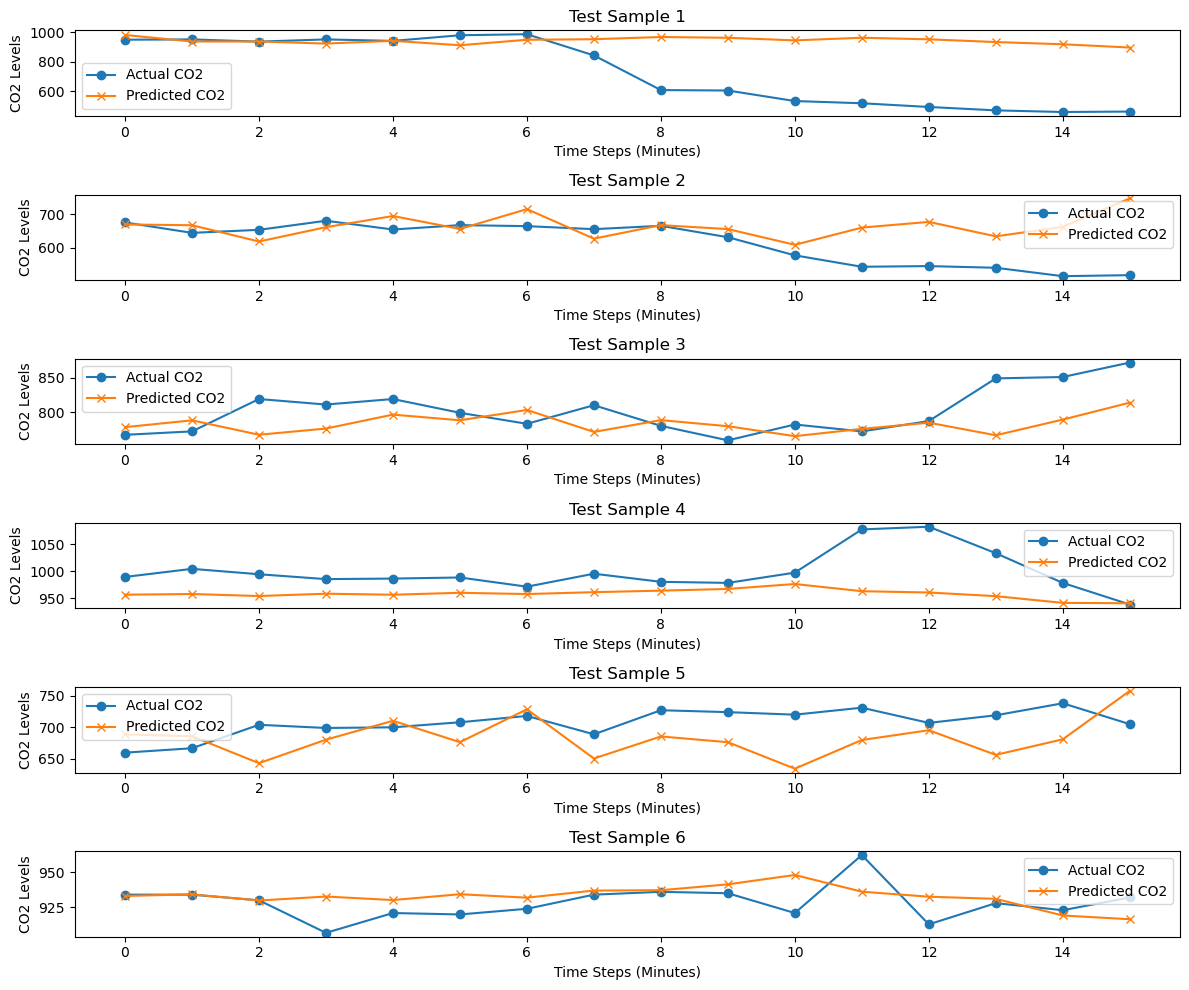

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming CO2 is the first feature in your scaled dataset
co2_mean = scaler.mean_[0]  # mean of the CO2 feature
co2_scale = scaler.scale_[0]  # scale of the CO2 feature


y_pred_co2_2d = y_pred_co2.reshape(-1, 1)
y_true_co2_2d = y_true_co2.reshape(-1, 1)
# Manually inverse transform the CO2 predictions and actual values
y_pred_co2_rescaled = (y_pred_co2_2d * co2_scale) + co2_mean
y_true_co2_rescaled = (y_true_co2_2d * co2_scale) + co2_mean

# Reshape back to the original shape if necessary
y_pred_co2_rescaled = y_pred_co2_rescaled.reshape(y_pred_co2.shape)
y_true_co2_rescaled = y_true_co2_rescaled.reshape(y_true_co2.shape)

import matplotlib.pyplot as plt

# Setup the plot with manually rescaled data
n_test_samples = y_test.shape[0]
plt.figure(figsize=(12, 10))
for i in range(n_test_samples):
    plt.subplot(n_test_samples, 1, i + 1)
    plt.plot(y_true_co2_rescaled[i], label='Actual CO2', marker='o')  # Manually rescaled actual values
    plt.plot(y_pred_co2_rescaled[i], label='Predicted CO2', marker='x')  # Manually rescaled predicted values
    plt.title(f'Test Sample {i+1}')
    plt.xlabel('Time Steps (Minutes)')
    plt.ylabel('CO2 Levels')
    plt.legend()

plt.tight_layout()
plt.show()


# Case II


In [21]:
C2 = windows_df

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X2, y = stack_dataframes_with_labels(C2)
T = X2.astype(np.float64)
# Encode labels: 'Song' as 1, 'Chen' as 0
y = np.array([1 if label == 'Song' else 0 for label in y])
# Scale the features using StandardScaler

Successfully stacked all DataFrames into a 3D NumPy array.
Shape of the final array X: (27, 76, 16)
Shape of the labels array y: (27,)


In [22]:

# Verify that the second dimension is divisible by 2
if T.shape[1] % 2 != 0:
    raise ValueError("The number of records in each layer must be divisible by 2")

# Reshape T directly to the new shape
# We reshape to (total number of new layers, new number of records per layer, number of features)
# Total number of new layers = original layers * 2 because we split each layer into 2
# New number of records per layer = original number of records per layer / 2
new_layers = T.shape[0] * 2
new_records_per_layer = T.shape[1] // 2
T = T.reshape(new_layers, new_records_per_layer, T.shape[2])

# Duplicate each element in y to match the new layer count
y = np.repeat(y, 2)

print("New shape of T:", T.shape)
print("New shape of y:", y.shape)

New shape of T: (54, 38, 16)
New shape of y: (54,)


In [23]:
# Reshape X to 2D array
T_2d = T.reshape(-1, T.shape[-1])

# Scale the features using StandardScaler
scaler = StandardScaler()
T_scaled = scaler.fit_transform(T_2d)

# Reshape X_scaled back to 3D array
T_scaled_3d = T_scaled.reshape(T.shape[0], T.shape[1], T.shape[2])

# Split into training and test/validation sets
T_train, T_test, y_train, y_test = train_test_split(T_scaled_3d, y, test_size=10, random_state=42, stratify=y)

print("X_train shape:", T_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", T_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (44, 38, 16)
y_train shape: (44,)
X_test shape: (10, 38, 16)
y_test shape: (10,)


Epoch 1/15
2/2 [==============================] - 0s 105ms/step - loss: 3.8783 - accuracy: 0.0455 - val_loss: 2.8453 - val_accuracy: 0.1000
Epoch 2/15
2/2 [==============================] - 0s 19ms/step - loss: 2.5839 - accuracy: 0.2500 - val_loss: 2.1535 - val_accuracy: 0.5000
Epoch 3/15
2/2 [==============================] - 0s 21ms/step - loss: 1.7528 - accuracy: 0.7727 - val_loss: 1.6559 - val_accuracy: 0.8000
Epoch 4/15
2/2 [==============================] - 0s 20ms/step - loss: 1.2343 - accuracy: 0.9091 - val_loss: 1.2740 - val_accuracy: 1.0000
Epoch 5/15
2/2 [==============================] - 0s 20ms/step - loss: 0.9218 - accuracy: 0.9091 - val_loss: 1.0244 - val_accuracy: 1.0000
Epoch 6/15
2/2 [==============================] - 0s 21ms/step - loss: 0.7306 - accuracy: 0.9318 - val_loss: 0.8562 - val_accuracy: 1.0000
Epoch 7/15
2/2 [==============================] - 0s 22ms/step - loss: 0.6024 - accuracy: 0.9773 - val_loss: 0.7203 - val_accuracy: 1.0000
Epoch 8/15
2/2 [==========

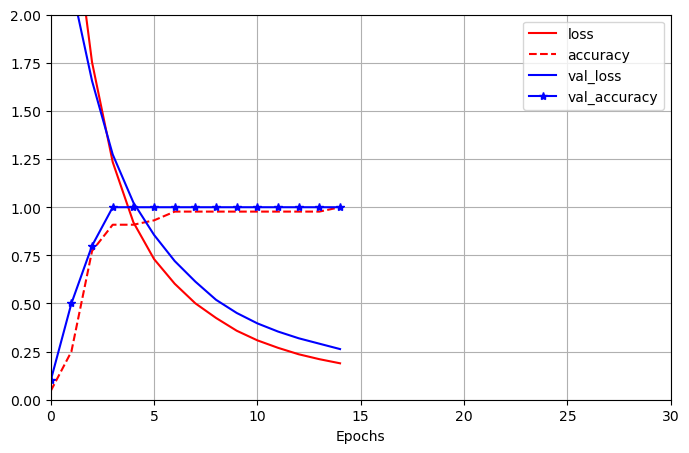

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[38,16]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(T_train, y_train, epochs=15, validation_data=(T_test, y_test))

pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 30], ylim=[0, 2], xlabel='Epochs', grid=True,
    style=['r', 'r--', 'b', 'b-*'])
plt.show()

In [25]:
print(model.evaluate(T_test, y_test))
y_proba = model.predict(T_test)
y_proba.round(2)
y_pred = np.argmax(y_proba, axis=1)
y_pred, y_test

metrics = evaluate_classification(y_test, y_pred)
print(metrics)

1/1 [==============================] - 0s 17ms/step - loss: 0.2631 - accuracy: 1.0000
[0.2630959749221802, 1.0]
1/1 [==============================] - 0s 35ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}



# Case III

In [26]:
C3 = windows_df

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X3, y = stack_dataframes_with_labels(C3)
T = X3.astype(np.float64)
# Encode labels: 'Song' as 1, 'Chen' as 0
y = np.array([1 if label == 'Song' else 0 for label in y])
# Scale the features using StandardScaler

Successfully stacked all DataFrames into a 3D NumPy array.
Shape of the final array X: (27, 76, 16)
Shape of the labels array y: (27,)


In [27]:
# Verify that the second dimension is divisible by 2
if T.shape[1] % 4 != 0:
    raise ValueError("The number of records in each layer must be divisible by 2")

# Reshape T directly to the new shape
# We reshape to (total number of new layers, new number of records per layer, number of features)
# Total number of new layers = original layers * 2 because we split each layer into 2
# New number of records per layer = original number of records per layer / 2
new_layers = T.shape[0] * 4
new_records_per_layer = T.shape[1] // 4
T = T.reshape(new_layers, new_records_per_layer, T.shape[2])

# Duplicate each element in y to match the new layer count
y = np.repeat(y, 4)

print("New shape of T:", T.shape)
print("New shape of y:", y.shape)

New shape of T: (108, 19, 16)
New shape of y: (108,)


In [28]:
# Reshape X to 2D array
T_2d = T.reshape(-1, T.shape[-1])

# Scale the features using StandardScaler
scaler = StandardScaler()
T_scaled = scaler.fit_transform(T_2d)

# Reshape X_scaled back to 3D array
T_scaled_3d = T_scaled.reshape(T.shape[0], T.shape[1], T.shape[2])

# Split into training and test/validation sets
T_train, T_test, y_train, y_test = train_test_split(T_scaled_3d, y, test_size=24, random_state=42, stratify=y)

print("X_train shape:", T_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", T_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (84, 19, 16)
y_train shape: (84,)
X_test shape: (24, 19, 16)
y_test shape: (24,)


Epoch 1/5
3/3 [==============================] - 0s 51ms/step - loss: 3.7350 - accuracy: 0.0238 - val_loss: 3.2624 - val_accuracy: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 0s 11ms/step - loss: 2.6651 - accuracy: 0.2619 - val_loss: 2.4685 - val_accuracy: 0.3750
Epoch 3/5
3/3 [==============================] - 0s 10ms/step - loss: 1.8831 - accuracy: 0.6310 - val_loss: 1.8946 - val_accuracy: 0.6250
Epoch 4/5
3/3 [==============================] - 0s 10ms/step - loss: 1.3674 - accuracy: 0.8214 - val_loss: 1.5096 - val_accuracy: 0.7500
Epoch 5/5
3/3 [==============================] - 0s 9ms/step - loss: 1.0500 - accuracy: 0.8929 - val_loss: 1.2489 - val_accuracy: 0.8750


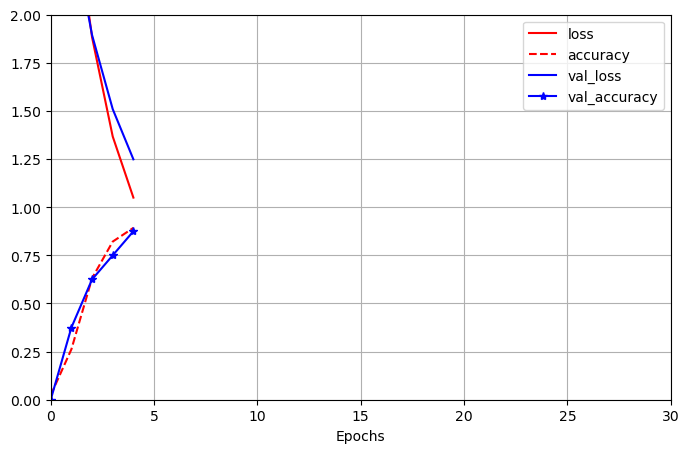

In [29]:
import tensorflow as tf
from sklearn.pipeline import Pipeline

# Set the random seed for TensorFlow
tf.random.set_seed(42)
tf.random.uniform([1], seed=1)
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[19, 16]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

# Create a pipeline with the model
pipeline = Pipeline([
    ('model', model)
])

# Fit the pipeline
history = pipeline['model'].fit(T_train, y_train, epochs=5, validation_data=(T_test, y_test))


pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 30], ylim=[0, 2], xlabel='Epochs', grid=True,
    style=['r', 'r--', 'b', 'b-*'])
plt.show()

In [30]:
print(model.evaluate(T_test, y_test))
y_proba = model.predict(T_test)
y_proba.round(2)
y_pred = np.argmax(y_proba, axis=1)
y_pred, y_test

metrics = evaluate_classification(y_test, y_pred)
print(metrics)

1/1 [==============================] - 0s 15ms/step - loss: 1.2489 - accuracy: 0.8750
[1.2488584518432617, 0.875]
1/1 [==============================] - 0s 31ms/step
Accuracy: 0.8750
Precision: 0.4000
Recall: 0.3500
F1-score: 0.3731
{'accuracy': 0.875, 'precision': 0.4, 'recall': 0.35, 'f1_score': 0.37312252964426873}


C:\Users\Corey Dearing\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
